# Table of Contents

1. [Import Packages](#import-packages)
2. [Import Mouse Metadata](#import-mouse-metadata)
3. [Import HMM file (Exported R csv)](#import-the-hmm-file)
4. [Plot 1: Heatmap Representations of HMM States](#plot-1-heatmap-representations-of-states)
<br>&nbsp;&nbsp;&nbsp;&nbsp;4.1. [Heatmap Representations of all genotypes](#heatmap-representations-of-all-genotypes-when-multiple-genotypes)
<br>&nbsp;&nbsp;&nbsp;&nbsp;4.2. [Interactive Heatmap version](#interactive-heatmap-version)
<br>&nbsp;&nbsp;&nbsp;&nbsp;4.3. [Interactive Heatmap version for all genotypes](#interactive-heatmap-version-of-all-genotypes-when-multiple-genotypes)
5. [Plot 2: Probability of Surveillance across Node Types and Regions](#plot-2-probability-of-surveillance-across-node-types-and-regions)
6. [Plot 3: Probability of States over Times](#plot-3-probability-of-states-over-time)
7. [Plot 4: Surveillance Probability by Bout Type](#plot-4-surveillance-probability-by-bout-type)

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# autoreload
%load_ext autoreload
%autoreload 2

In [ ]:
CUSTOM_UTILS_PATH = Path(os.getcwd()).parent/'src'/'post_hoc_analysis'/'level_1'
if CUSTOM_UTILS_PATH.exists():
    sys.path.append(str(CUSTOM_UTILS_PATH))
    # Import custom analysis modules
    try:
        import bout_analysis
        from bout_analysis import *
        import grid_heatmap
        from grid_heatmap import *
        import spatial_analysis
        from spatial_analysis import *
        import temporal_analysis
        from temporal_analysis import *
        print("Utils loaded successfully!")
    except ImportError as e:
        print(f"Warning: Could not import custom modules: {e}")
else:
    print(f"Warning: Custom utils path not found: {CUSTOM_UTILS_PATH}")


import init_config
from init_config import *

import notebook_utils
from notebook_utils import *

In [4]:
import matplotlib
matplotlib.rcParams['font.family'] = 'Arial'
matplotlib.rcParams['svg.fonttype'] = 'none'
matplotlib.rcParams['pdf.fonttype'] = 42

# Import Mouse Metadata

In [ ]:
# Read in mouse metadata file
mouseinfo = pd.read_excel(os.path.join(METADATA_PATH,METADATA_FILE), sheet_name=TRIAL_TYPE)
print('Metadata columns: ',mouseinfo.columns)

# Consider only non-NA Sessions
mouseinfo = mouseinfo[~mouseinfo['Session #'].isna()]

# Find the subset of trials need to be excluded
mouseinfo = mouseinfo.loc[mouseinfo['Exclude Trial']!= 'yes'].reset_index(drop=True)

# Import the HMM file

In [ ]:
df_hmm = pd.read_csv(os.path.join(BASE_PATH,'csvs','combined','HMM_2state_file.csv'))
df_hmm.reset_index(drop=True,inplace=True)

# State Representation: Characteristics

### State 1 --> Low Step Length, High Turn Angle --> "Surveillance" state (Red)
### State 2 --> High Step Length, Low Turn Angle --> "Ambulatory" state (Blue)

# Plot 1: Heatmap Representations of HMM States

Decision Nodes highlighted in BLACK
Target Nodes highlighted in YELLOW


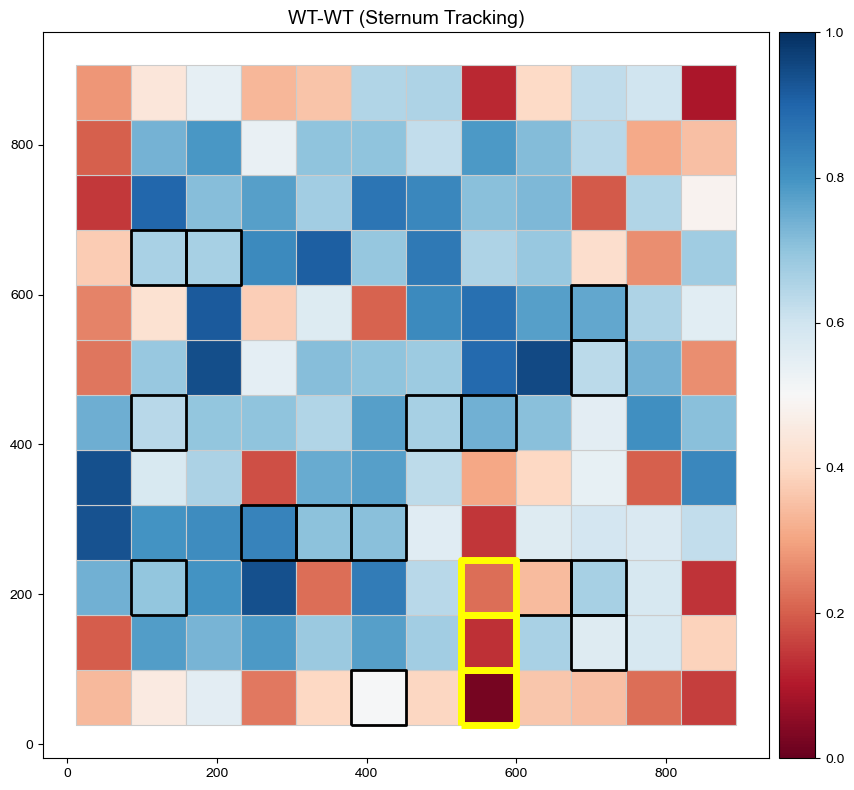

In [7]:
# =================== USAGE EXAMPLE =================== #
# This workflow visualizes the spatial distribution of HMM state proportions 
# over a grid-mapped maze using heatmaps. It overlays key regions such as 
# decision and target nodes for the specified genotype.

# Recommended Use:
# ----------------
# 1. Ensure `df_hmm` contains columns: 'Genotype', 'Grid.Number', 'HMM_State', 'x', and 'y'.
# 2. Set `genotype_name` to the genotype of interest (e.g., 'WT-WT').
# 3. Set `grid_filename` to the corresponding shapefile for the session.
# 4. Use `compute_state_proportion()` to calculate per-grid HMM state proportions.
# 5. Load the grid geometry using `create_grid_geodata()`.
# 6. Use `map_points_to_grid()` and `sjoin()` to align state estimates with grid polygons.
# 7. Merge state proportions back into the grid using `merge_state_proportions_to_grid()`.
# 8. Plot the heatmap using `plot_grid_heatmap()` and highlight decision/target regions.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
genotype_name = 'WT-WT'
grid_filename = "Session-3 grid.shp"


#________________________________________________
# Step 1: Compute HMM state proportions by grid
state_df = compute_state_proportion(df_hmm, genotype_name)

# Step 2: Load session-specific grid geometry
grid = create_grid_geodata(GRID_PATH, grid_filename)

# Step 3: Map mean (x, y) points to grid polygons
pnt_gpd = map_points_to_grid(state_df, grid)
pointInPolys = gpd.tools.sjoin(pnt_gpd, grid, predicate="within", how='left')

# Step 4: Merge proportions with grid polygons
grid_mapped = merge_state_proportions_to_grid(grid, state_df)

# Step 5: Plot heatmap with overlays for Decision and Target zones
ax = plot_grid_heatmap(grid_mapped, genotype_name, 
                       highlight_grids=Decision_Reward,
                       target_grids=Target_Zone)

print('Decision Nodes highlighted in BLACK')
print('Target Nodes highlighted in YELLOW')


## Heatmap representations of all genotypes (when multiple genotypes)

In [ ]:
plot_all_genotype_heatmaps(
    df_hmm=df_hmm,
    grid_path=GRID_PATH,
    grid_filename = grid_filename,
    highlight_grids=Decision_Reward,
    target_grids=Target_Zone,
    hmm_state=2,
    cmap='RdBu'
)

## Interactive Heatmap version

In [9]:
#--------------- SET THESE VALUES --------------#
genotype_name = 'WT-WT'


#________________________________________________
# 1. Compute state proportions
state_df = compute_state_proportion(df_hmm, genotype_name)

# 2. Load shapefile
grid = create_grid_geodata(GRID_PATH, grid_filename)

# 3. Merge proportion values to grid
grid_mapped = grid.copy()
grid_mapped = grid_mapped.merge(
    state_df[['Grid.Number', 'prop']],
    left_on='FID', right_on='Grid.Number',
    how='left'
)
grid_mapped = grid_mapped.rename(columns={'prop': 'State1_Proportion'})

# 4. Get grid centroids
grid_centroids = get_grid_centroids(grid_mapped)

# 5. Plot heatmap
fig = plot_interactive_heatmap(grid_mapped, Decision_Reward, Target_Zone, genotype_name)

# 6. Overlay smooth trajectory lines
overlay_trajectory_lines_plotly(fig, df_hmm, genotype_name, grid_centroids, top_percent=1)

# 7. Show
fig.show()


## Interactive Heatmap version of all genotypes (when multiple genotypes)

In [ ]:
plot_all_genotype_interactive_heatmaps(
    df_hmm=df_hmm,
    grid_path=GRID_PATH,
    grid_filename="Session-3 grid.shp",
    decision_fids=Decision_Reward,
    target_fids=Target_Zone,
    hmm_state=2,
    top_percent=1
)


# Plot 2: Probability of Surveillance across Node Types and Regions

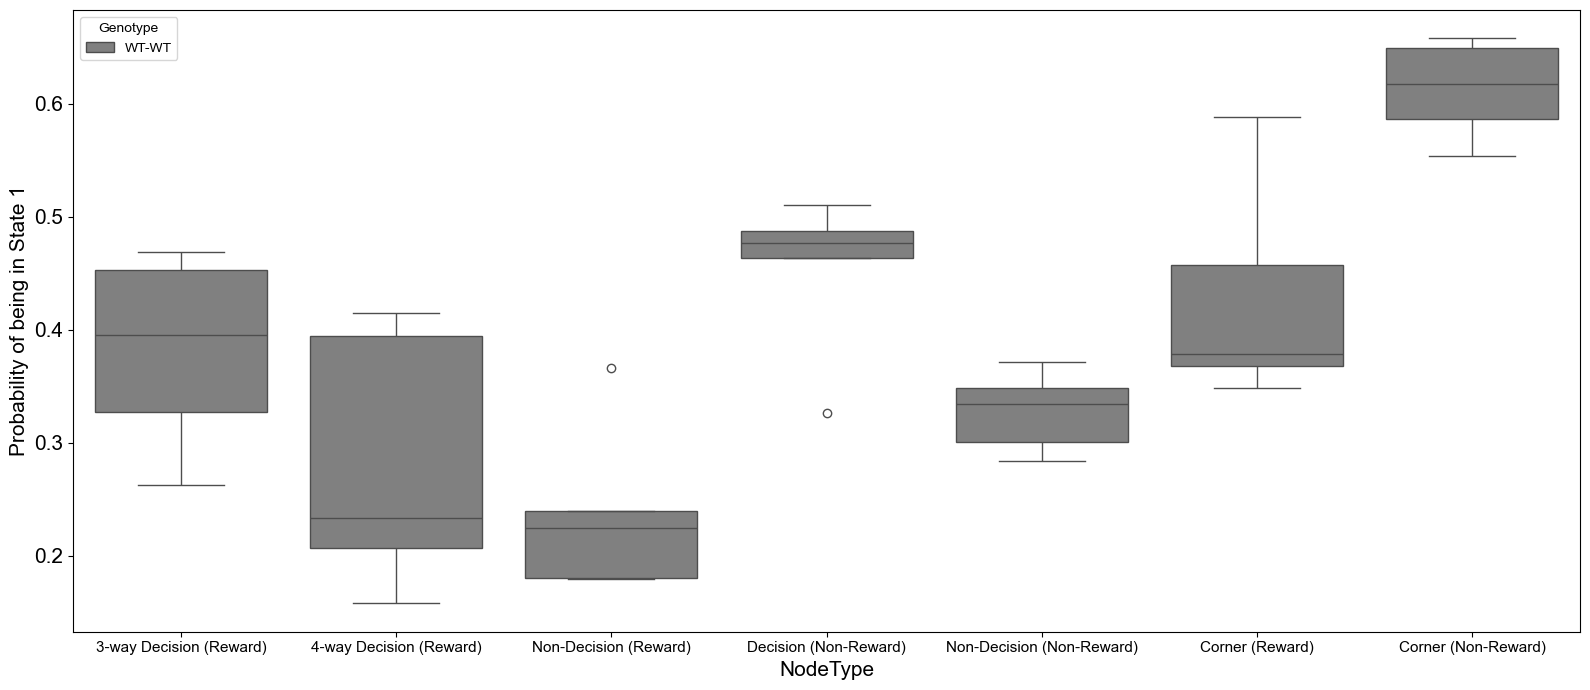

In [15]:
# =================== USAGE EXAMPLE =================== #
# This workflow computes and visualizes the probability of HMM state occupancy
# across behavioral Node Types/Regions

# Recommended Use:
# ----------------
# 1. Ensure `df_hmm` includes 'Genotype', 'Session', 'HMM_State', 'NodeType', and 'Grid.Number'.
# 2. If analyzing decision complexity, pass lists of `decision_3way` and `decision_4way` grid numbers.
# 3. Use `compute_state_probability()` to get HMM state proportions per category.
# 4. Use `plot_state_probability_boxplot()` to visualize across genotypes.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
column_of_interest = 'NodeType'
values_displayed = [
    '3-way Decision (Reward)', '4-way Decision (Reward)','Non-Decision (Reward)', 
    'Decision (Non-Reward)', 'Non-Decision (Non-Reward)',
    'Corner (Reward)', 'Corner (Non-Reward)'
]
state = 1
figsize = (16, 7)

#___________________________________________________________________________
# Step 1: Compute proportions
state_count_df = compute_state_probability(
    df_hmm=df_hmm,
    column_of_interest=column_of_interest,
    values_displayed=values_displayed,
    decision_3way=Decision_3way,
    decision_4way=Decision_4way,
    state=state
)


# Step 2: Plot boxplot
ax = plot_state_probability_boxplot(
    state_count=state_count_df,
    column_of_interest=column_of_interest,
    state=state,
    figsize=figsize,
    palette=PALETTE
)


In [ ]:
## STATISTICAL TESTS ONLY IF MULTIPLE GENOTYPES

# T-tests amongst genotypes per category
ttest_results = run_pairwise_ttests(state_count_df, column_of_interest='NodeType')
print(ttest_results.sort_values("P-value"))

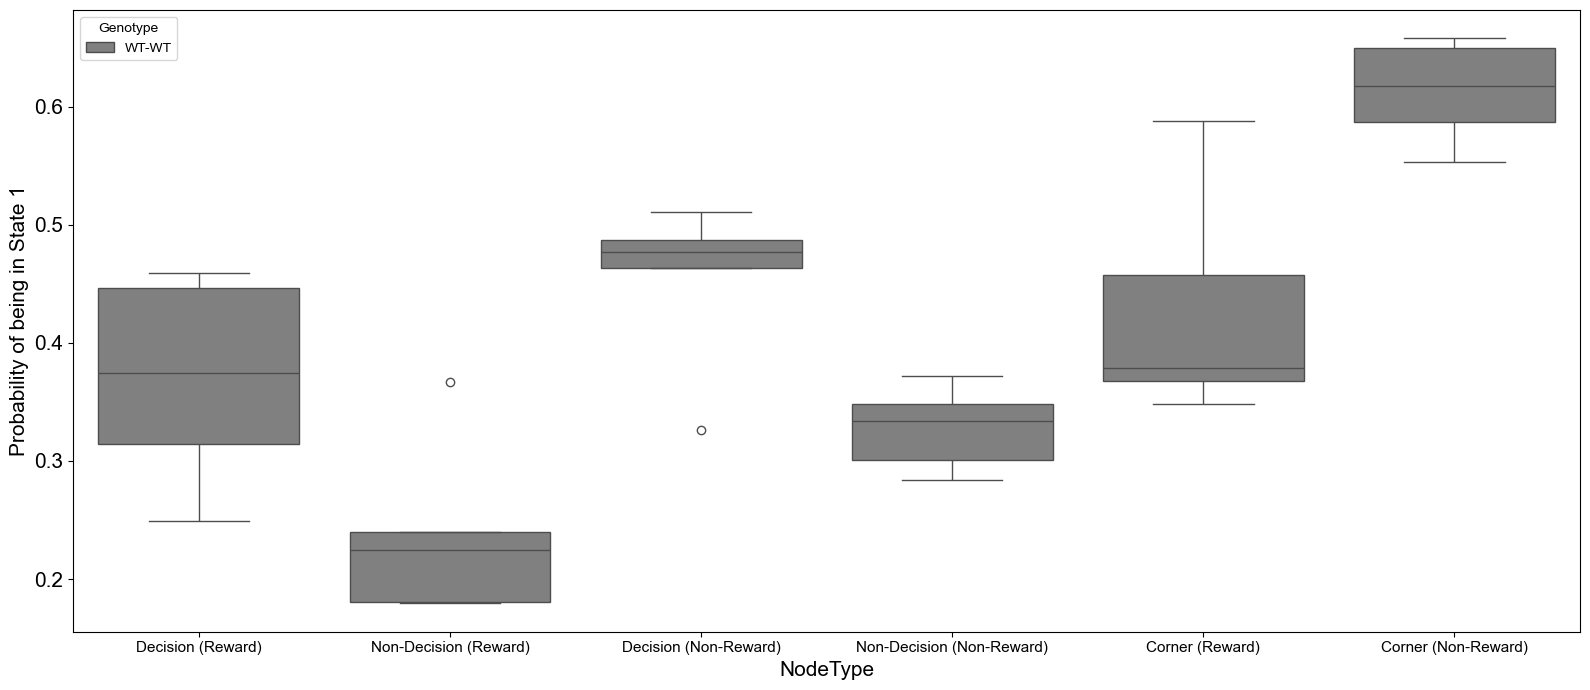

In [18]:
# =================== USAGE EXAMPLE =================== #
# This workflow computes and visualizes the probability of HMM state occupancy
# across behavioral Node Types/Regions

# Recommended Use:
# ----------------
# 1. Ensure `df_hmm` includes 'Genotype', 'Session', 'HMM_State', 'NodeType', and 'Grid.Number'.
# 2. If analyzing decision complexity, pass lists of `decision_3way` and `decision_4way` grid numbers.
# 3. Use `compute_state_probability()` to get HMM state proportions per category.
# 4. Use `plot_state_probability_boxplot()` to visualize across genotypes.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
column_of_interest = 'NodeType'
values_displayed = [
    'Decision (Reward)', 'Non-Decision (Reward)', 
    'Decision (Non-Reward)', 'Non-Decision (Non-Reward)', 
    'Corner (Reward)', 'Corner (Non-Reward)'
]
state = 1
figsize = (16, 7)

#___________________________________________________________________________
# Step 1: Compute proportions
state_count_df = compute_state_probability(
    df_hmm=df_hmm,
    column_of_interest=column_of_interest,
    values_displayed=values_displayed,
    decision_3way=None,
    decision_4way=None,
    state=state
)


# Step 2: Plot boxplot
ax = plot_state_probability_boxplot(
    state_count=state_count_df,
    column_of_interest=column_of_interest,
    state=state,
    figsize=figsize,
    palette=PALETTE
)



In [ ]:
## STATISTICAL TESTS ONLY IF MULTIPLE GENOTYPES

# T-tests amongst genotypes per category
ttest_results = run_pairwise_ttests(state_count_df, column_of_interest='NodeType')
print(ttest_results.sort_values("P-value"))

# Plot 3: Probability of States over Time

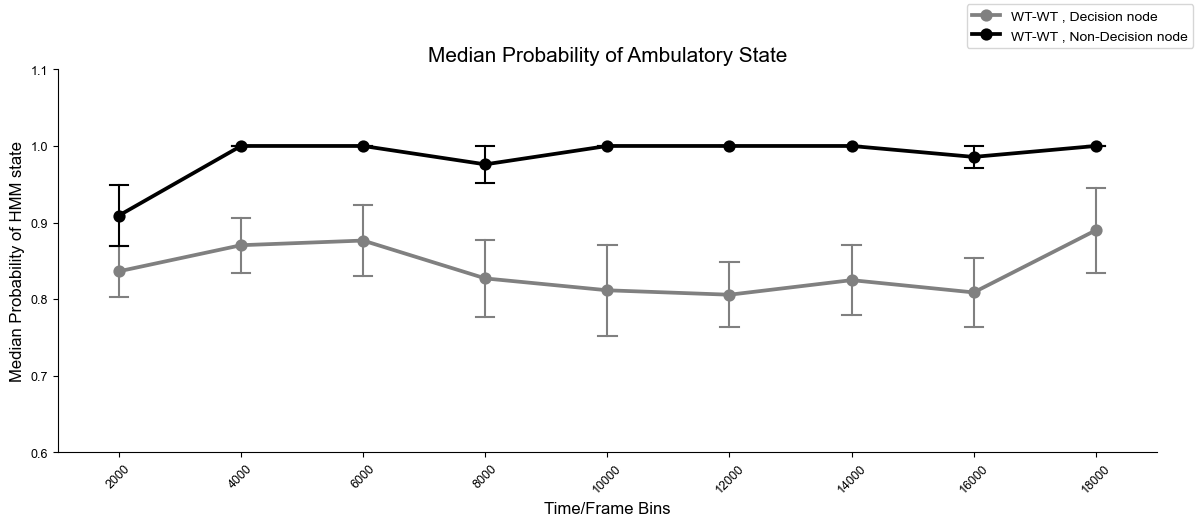

In [45]:
# =================== USAGE EXAMPLE =================== #
# This workflow analyzes how the probability of being in a specific HMM state
# (e.g., State 2) evolves over time at decision vs. non-decision nodes.
# It computes median probabilities across sessions using sliding time bins
# and plots the resulting curves to compare decision-related dynamics.

# Recommended Use:
# ----------------
# 1. Ensure `df_hmm` contains columns: 'Time', 'Session', 'Grid.Number', 'HMM_State', 'NodeType', and 'Genotype'.
# 2. Define grid numbers corresponding to `Decision_Reward` and `NonDecision_Reward` nodes.
# 3. Set a time window (`lower_limit` to `upper_limit`) and a `bin_size` (e.g., 2000 frames) to compute time bins.
# 4. Use `compute_node_state_medians_over_time()` to calculate median state occupancy at decision vs. non-decision nodes.
# 5. Optionally filter the resulting DataFrame (`Deci_DF`) using a `threshold` to only keep early time bins.
# 6. Visualize the trajectory of state occupancy using `plot_node_state_median_curve()`.

# Example Workflow:
# -----------------

#--------------- SET THESE VALUES --------------#
lower_limit = 0
upper_limit = get_max_session_row_bracket(df_hmm)
bin_size = 2000
threshold =  get_min_session_row_bracket(df_hmm)  # Only show bins where all sessions are present
palette = [ 'grey','black']
figure_ylimit = (0.6, 1.1)

#___________________________________________________________________________
# Step 1: Compute median probability of being in State 1 across time bins
Deci_DF = compute_node_state_medians_over_time(
    df_hmm=df_hmm,
    state_types=[2],
    decision_nodes=Decision_Reward,
    nondecision_nodes=NonDecision_Reward,
    lower_lim=lower_limit,
    upper_lim=upper_limit,
    bin_size=bin_size
)

# Step 2: Optional filter to only plot early session bins
Deci_DF = Deci_DF.loc[Deci_DF.Time_Bins < threshold]


# Step 3: Plot time-evolving median probability curves
plot_node_state_median_curve(
    Deci_DF,
    palette=palette,
    figure_ylimit=figure_ylimit,
    fig_title = 'Median Probability of Ambulatory State'
)

# Plot 4: Surveillance Probability by Bout Type

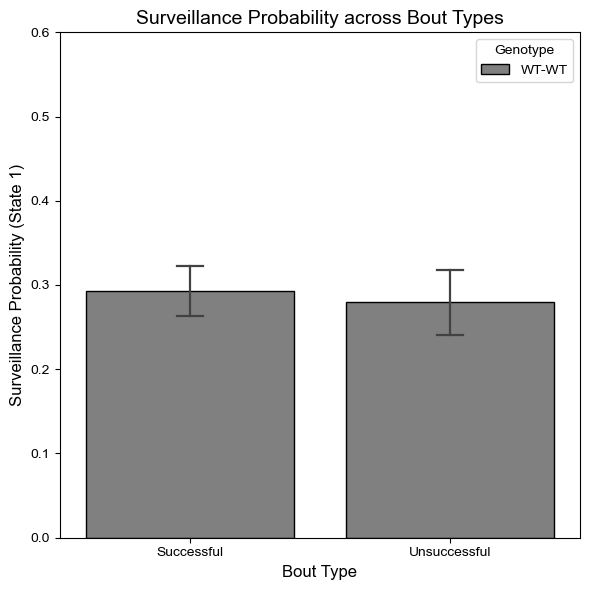

In [25]:
# =================== USAGE EXAMPLE =================== #
# This workflow evaluates behavioral surveillance patterns at decision nodes 
# across navigational bouts in the maze. It segments the session into bouts, 
# computes  surveillance probability for each bout at decision nodes, 
# and visualizes the average surveillance behavior across successful and unsuccessful bouts.

# Recommended Use:
# ----------------
# 1. Ensure `df_hmm` contains columns: 'Grid.Number', 'Session', 'Genotype', and maze node annotations.
# 2. Use `assign_bout_indices()` to segment sessions into bouts based on re-entries into the maze (e.g., delimiter node 47).
# 3. Run `compute_surveillance_probabilities()` to calculate surveillance at specified decision nodes for each bout.
# 4. Use `plot_surveillance_by_bout()` to generate a grouped barplot comparing surveillance probability between successful and unsuccessful bouts, including a t-test p-value.

# Example Workflow:
# -----------------

df_hmm = assign_bout_indices(df_hmm, delimiter_node=47) # Assign Bout Numbers #Bout = Entry node 47 --> Other non-entry nodes --> Entry node 47

index_df = compute_surveillance_probabilities(df_hmm, Decision_Reward) # Compute surveillance probability at Decision nodes by Bout type : Successful-> reached the target atleast once/Unsuccessful-> doesn't reached the target
median_df = (
    index_df.dropna()
    .groupby(['Genotype', 'Session', 'Successful_bout'])['Probability_1']
    .median()
    .reset_index()
)

plot_surveillance_by_bout(median_df,ylim=0.6,figure_size=(6,6),palette=PALETTE) #Barplot to depict the above with ttest-ind pvalue

In [26]:
# LMM for same genotype comparison across Bout types
df_within = run_within_genotype_mixedlm_with_fdr(median_df)

# Print results
print("Within-Genotype (Successful vs Unsuccessful):")
print(df_within)

Within-Genotype (Successful vs Unsuccessful):
  Genotype  Effect: Successful vs Unsuccessful   P-value  FDR P-value  \
0    WT-WT                            0.013694  0.382404     0.382404   

   Significant (FDR < 0.05)  
0                     False  


In [ ]:
## STATISTICAL TESTS ONLY IF MULTIPLE GENOTYPES


# T-test across genotypes under Successful Bouts
df_across_success = test_across_genotypes_per_bout(median_df, bout_type='Successful')

# T-test across genotypes under Unsuccessful Bouts
df_across_unsuccess = test_across_genotypes_per_bout(median_df, bout_type='Unsuccessful')

# Print results
print("\n Across Genotypes (Successful only):")
print(df_across_success)

print("\n Across Genotypes (Unsuccessful only):")
print(df_across_unsuccess)


In [ ]:
# Convert to HTML report and save as a pdf if needed after

#! pip install nbconvert
! jupyter nbconvert "03_level_1_post_analysis.ipynb" \
  --to html \
  --TemplateExporter.exclude_input=True \
  --output "03_level_1_post_analysis.html"
